In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import DistanceMetric
from gp_mjo.gp_mjo_model import rolling

In [2]:
npzfile = np.load('../data/mjo_new_data.npz', allow_pickle=True)
print(npzfile.files)
print(npzfile['RMM1'].shape)

data_names = npzfile.files + ['id']
n_files = len(data_names)

entire_npzfile = {}
for i, data_name in enumerate(data_names):
    if i < n_files-1:
        entire_npzfile[data_name] = npzfile[data_name]
    if i == n_files-1:
        entire_npzfile[data_name] = np.arange(len(npzfile['RMM1']))

['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
(16026,)


In [5]:
class emp_gp_mjo:
    def __init__(self, npzfile, width=30, n = 10000, start_train=0, season_bool=False) -> None:
        self.npzfile = npzfile
        self.width = width
        self.n = n
        self.start_train = start_train
        self.n_train = width + n

        errlist = ['cor','rmse','phase','amplitude']
        self.errs = {key: None for key in errlist}

        train_x = np.array([])
        train_y = np.array([])
        train_ids = np.arange(start_train, start_train + self.n_train)
        for rmm in ['RMM1','RMM2']:
            if season_bool:
                train_xrmm = np.array([]).reshape(-1, width)
                train_yrmm = np.array([]).reshape(-1, 1)
                train_id_split = np.hstack( ( np.array([0]), 
                            np.where(np.ediff1d(npzfile['id'][train_ids]) != 1 )[0]+1, 
                            np.array([len(npzfile['id'][train_ids])]) ) )
                diff_train_ids = np.ediff1d(train_id_split)
                for i, diff_train_id in enumerate(diff_train_ids):
                    if diff_train_id <= width:
                        print(f'width = {width} is greater than the current interval width {diff_train_id}, will skip {i}-th iteration for {rmm}')
                        continue
                    split_start = train_id_split[i]
                    split_end = train_id_split[i+1]
                    train_ij = npzfile[rmm][train_ids][split_start:split_end]
                    
                    train_xrmm = np.vstack(( train_xrmm, rolling(train_ij[:-1], width) )) # (n, width) numpy array
                    train_yrmm = np.vstack(( train_yrmm, train_ij[width:].reshape(-1,1) )) # (n, 1) numpy array
            
            else:    
                train_ij = npzfile[rmm][train_ids]
                train_xrmm = rolling(train_ij[:-1], width) # (n, width) numpy array
                train_yrmm = train_ij[width:].reshape(-1,1) # (n, 1) numpy array
            
            train_x = train_x.reshape(train_xrmm.shape[0], -1)
            train_y = train_y.reshape(train_yrmm.shape[0], -1)

            train_x = np.hstack(( train_x, train_xrmm )) # (n, 2*width) numpy array
            train_y = np.hstack( (train_y, train_yrmm) ) # (n, 2) numpy array

        self.train_x = train_x
        self.train_y = train_y

            # self.train_x1 = rolling(npzfile['RMM1'][start_train : start_train + self.n_train - 1], width) # (n, width) numpy array
            # self.train_x2 = rolling(npzfile['RMM2'][start_train : start_train + self.n_train - 1], width) # (n, width) numpy array
            # self.train_x = np.hstack((self.train_x1,self.train_x2)) # (n, 2*width) numpy array

            # self.train_y1 = npzfile['RMM1'][start_train + width : start_train + self.n_train] # (n, ) numpy array
            # self.train_y2 = npzfile['RMM2'][start_train + width : start_train + self.n_train] # (n, ) numpy array
            # self.train_y = np.hstack((self.train_y1[:,None], self.train_y2[:,None])) # (n, 2) numpy array


    def get_emp(self):
        n = self.n
        width = self.width
        train_x = self.train_x
        train_y = self.train_y
        
        train_joint = np.hstack((train_x, train_y)) # (n, 2*width+2) numpy array

        self.train_jointmean = np.mean(train_joint, axis=0)[None,:] # (1, 2*width+2) numpy array
        self.train_jointcov = (train_joint - self.train_jointmean).T @ (train_joint - self.train_jointmean) / (n-1) # (2*width+2, 2*width+2) numpy array

        self.mu1 = self.train_jointmean[:,:2*width].T # (2*width, 1) numpy array
        self.mu2 = self.train_jointmean[:,2*width:].T # (2, 1) numpy array

        self.K11 = self.train_jointcov[:2*width, :2*width] # (2*width, 2*width) numpy array
        self.K12 = self.train_jointcov[:2*width, 2*width:] # (2*width, 2) numpy array
        self.K21  = self.train_jointcov[2*width:, :2*width] # (2, 2*width) numpy array
        self.K22  = self.train_jointcov[2*width:, 2*width:] # (2, 2) numpy array

        self.K11_inv = np.linalg.inv(self.K11) # (2*width, 2*width) numpy array
        self.Kcond = self.K22 - self.K21 @ self.K11_inv @ self.K12 # (2,2) numpy array
        self.std = np.sqrt(np.diag(self.Kcond, k=0)) # (2,) numpy array

        dist = DistanceMetric.get_metric('euclidean')
        self.dist_joint = dist.pairwise(train_joint.T)

    def pred(self, start_test, lead_time = 60, n_pred = 1, m = 1500, season_bool=False):
        npzfile = self.npzfile
        width = self.width
        test_ids = np.arange(start_test, start_test + m)
        # test_x1 = self.npzfile['RMM1'][self.start_test : self.start_test + self.m] # (m, ) numpy array
        # test_x2 = self.npzfile['RMM2'][self.start_test : self.start_test + self.m] # (m, ) numpy array
        # test_x = np.hstack((test_x1[:,None], test_x2[:,None])) # (m, 2) numpy array

        test_id_split = np.hstack( ( np.array([0]), 
                            np.where(np.ediff1d(npzfile['id'][test_ids]) != 1 )[0]+1, 
                            np.array([len(npzfile['id'][test_ids])]) ) )
        diff_test_ids = np.ediff1d(test_id_split)
        max_diff = np.max(diff_test_ids)
        freq_diff = np.bincount(diff_test_ids).argmax() # return the most frequent value in diff_test_ids
    
        if season_bool or len(test_id_split) > 2:
            if width >= freq_diff:
                raise ValueError(f'the width is greater than the season interval, please try a width value < {freq_diff}')
            if lead_time + width > freq_diff:
                print(f"the sum of the width and lead time is greater than the season interval..., will set lead time = {freq_diff-width}")
                lead_time = freq_diff-width
            
            pred_ids_start = test_id_split[:-1]
            pred_ids_end = (test_id_split - lead_time - width + 1)[1:]
            pred_ids = np.array([],dtype=int)
            for ii in range(len(pred_ids_start)):
                if (pred_ids_start[ii] >= pred_ids_end[ii]):
                    continue
                pred_ids_i = np.arange( start=pred_ids_start[ii], stop=pred_ids_end[ii] )
                pred_ids = np.hstack( (pred_ids,pred_ids_i), dtype=int)
            
            if n_pred > len(pred_ids):
                print(f"the number of predictions is greater than the number of the season intervals..., will set n_pred = {len(pred_ids)}")
                n_pred = len(pred_ids)            
            
        else:
            pred_ids = np.arange(n_pred)
        
        obs = {}
        observed_preds = {}
        lower_confs = {}
        upper_confs = {}

        obs['amplitude'] = np.zeros((n_pred,lead_time))
        rmms = ['RMM1','RMM2']
        for rmm in rmms:
            obs[rmm] = np.zeros((n_pred,lead_time))
            observed_preds[rmm] = np.zeros((n_pred,lead_time))
            lower_confs[rmm] = np.zeros((n_pred,lead_time))
            upper_confs[rmm] = np.zeros((n_pred,lead_time))

        for i, pred_i in enumerate(pred_ids[:n_pred]):
            input_xij = {}
            for j in range(lead_time):
                input_x = np.array([]).reshape((-1, 1))
                obs['amplitude'][i,j] = npzfile['amplitude'][test_ids][pred_i+j+width]
                for rmm in rmms:
                    obs[rmm][i,j] = npzfile[rmm][test_ids][pred_i+j+width]
                    if j == 0:
                        input_xij[rmm] = npzfile[rmm][test_ids][pred_i+j : pred_i+j+self.width][:, None] # (width, 1) numpy array
                    else:
                        last_pred_x = observed_preds[rmm][i,j-1]
                        input_xij[rmm] = np.vstack(( input_xij[rmm][1:,:], last_pred_x )).reshape((-1,1)) # (width, 1) numpy array

                    input_x = np.vstack((input_x, input_xij[rmm])) # (2*width, 1) numpy array
                    
                observed_pred = self.mu2 + self.K21 @ self.K11_inv @ (input_x - self.mu1) # (2, 1) numpy array
                
                for k, rmm in enumerate(rmms):
                    observed_preds[rmm][i,j] = observed_pred[k,:]
                    lower_confs[rmm][i,j] = observed_pred[k,:] - self.std[k]
                    upper_confs[rmm][i,j] = observed_pred[k,:] + self.std[k]

        self.lead_time = lead_time
        self.n_pred = n_pred
        self.m = m
        self.start_test = start_test
        self.pred_ids = pred_ids
        
        self.obs = obs
        self.observed_preds = observed_preds
        self.lower_confs = lower_confs
        self.upper_confs = upper_confs

    def rmm_to_amplitude(self, pred_rmm1=None, pred_rmm2=None):
        """ampltitude is the norm of (RMM1, RMM2)
        """
        if pred_rmm1 is None:
            pred_rmm1 = self.observed_preds['RMM1']
        if pred_rmm2 is None:
            pred_rmm2 = self.observed_preds['RMM2']
        amplitude = np.sqrt( np.square(pred_rmm1) + np.square(pred_rmm2) )
        self.observed_preds['amplitude'] = amplitude
        return amplitude

    
    def cor(self):
        """bivariate correlation coefficien
        """
        pred_rmm1 = self.observed_preds['RMM1']
        pred_rmm2 = self.observed_preds['RMM2']

        obs_rmm1 = self.obs['RMM1']
        obs_rmm2 = self.obs['RMM2']

        numerator = np.sum((obs_rmm1*pred_rmm1 + obs_rmm2*pred_rmm2), axis=0) # 1*lead_time numpy array
        denominator = np.sqrt(np.sum((obs_rmm1**2 + obs_rmm2**2),axis=0)) \
            * np.sqrt(np.sum((pred_rmm1**2 + pred_rmm2**2),axis=0))
        self.errs['cor'] = (numerator / denominator).reshape(-1) # shape = (lead_time,) numpy array

        return self.errs['cor']
    
   
    def rmse(self):
        pred_rmm1 = self.observed_preds['RMM1']
        pred_rmm2 = self.observed_preds['RMM2']

        obs_rmm1 = self.obs['RMM1']
        obs_rmm2 = self.obs['RMM2']
        n_pred = pred_rmm1.shape[0]

        sum_rmm1 = np.sum((obs_rmm1-pred_rmm1)**2, axis=0)
        sum_rmm2 = np.sum((obs_rmm2-pred_rmm2)**2, axis=0)
        self.errs['rmse'] = ( np.sqrt( (sum_rmm1 + sum_rmm2) / n_pred ) ).reshape(-1)

        return self.errs['rmse']


    def phase_err(self):
        pred_rmm1 = self.observed_preds['RMM1']
        pred_rmm2 = self.observed_preds['RMM2']

        obs_rmm1 = self.obs['RMM1']
        obs_rmm2 = self.obs['RMM2']
        n_pred = pred_rmm1.shape[0]

        num = obs_rmm1*pred_rmm2 - obs_rmm2*pred_rmm1
        den = obs_rmm1*pred_rmm1

        temp = np.arctan(np.divide(num,den))
        self.errs['phase'] = ( np.sum(temp, axis=0) / n_pred ).reshape(-1)

        return self.errs['phase']

   
    def amplitude_err(self):
        pred_rmm1 = self.observed_preds['RMM1']
        pred_rmm2 = self.observed_preds['RMM2']
        n_pred = pred_rmm1.shape[0]
        preds_amplitude = self.rmm_to_amplitude(pred_rmm1,pred_rmm2)
        
        obs_amplitude = self.obs['amplitude']

        self.errs['amplitude'] = (np.sum((preds_amplitude - obs_amplitude),axis=0) / n_pred).reshape(-1)

        return self.errs['amplitude']


## Entire

In [6]:
width = 30
n = 10000
m = 3000
lead_time = 60
start_train = 0
n_offset = 0
n_pred = 365*3

n_train = width + n
start_test = start_train + n_train + n_offset

emp_model = emp_gp_mjo(npzfile=entire_npzfile, width=width, n=n, start_train =start_train)
emp_model.get_emp()
emp_model.pred(start_test=start_test, lead_time=lead_time, n_pred=n_pred, m=m)

# compute errors
cor_entire = emp_model.cor()
rmse_entire = emp_model.rmse()
phase_err_entire = emp_model.phase_err()
amplitude_err_entire = emp_model.amplitude_err()

dist_joint = emp_model.dist_joint
train_jointcov = emp_model.train_jointcov

obs = emp_model.obs
observed_preds = emp_model.observed_preds
lower_confs = emp_model.lower_confs
upper_confs = emp_model.upper_confs

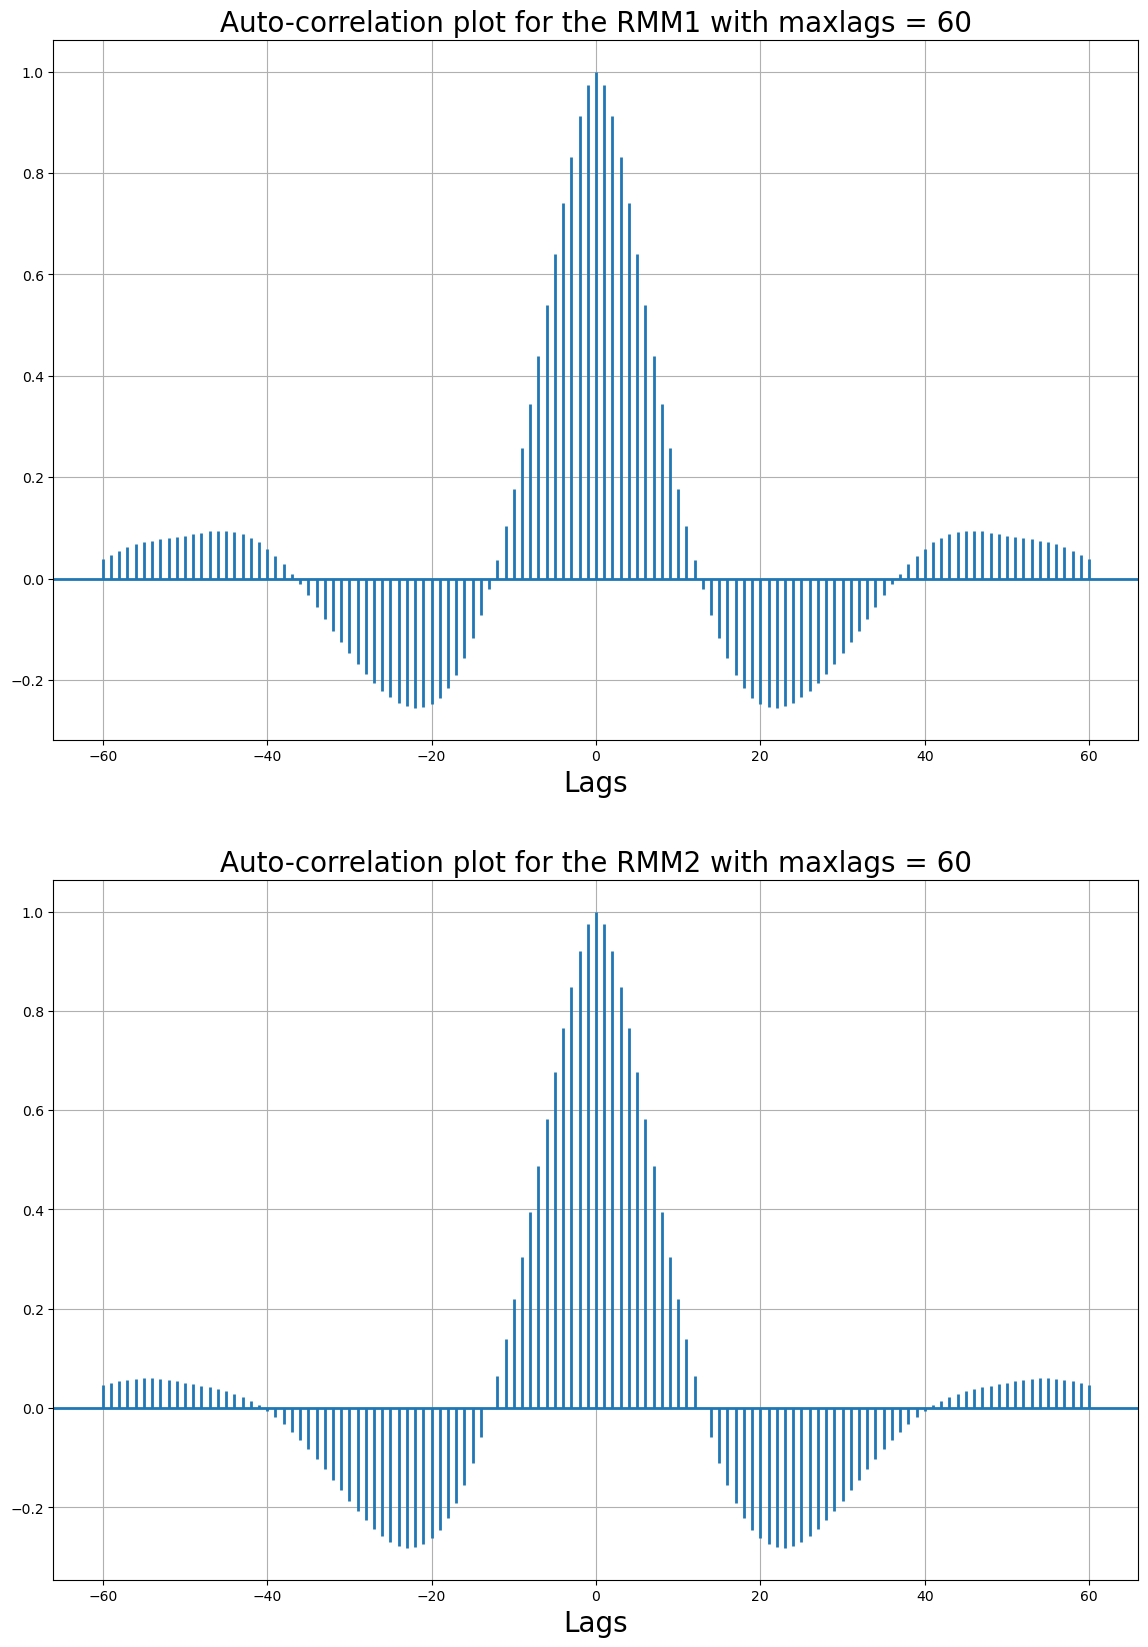

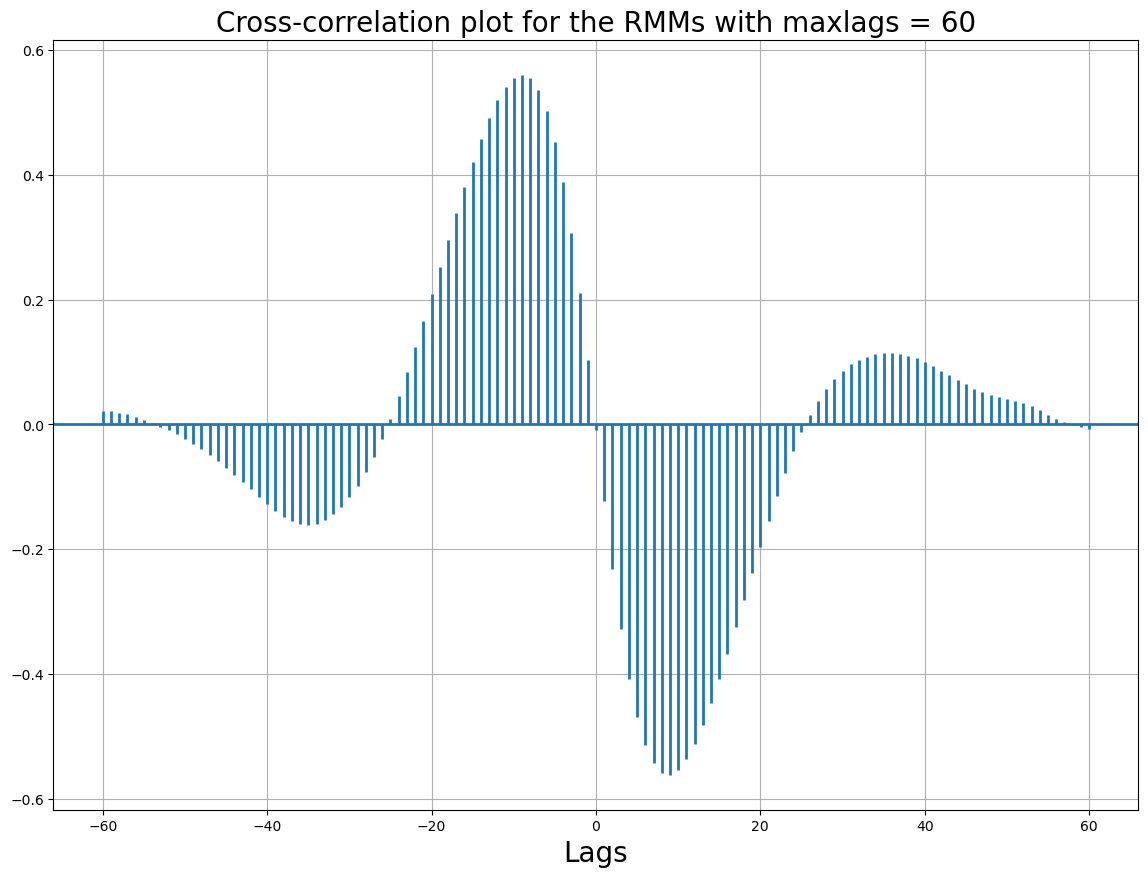

In [7]:
# Plot auto-correlation and cross-correlation
maxlags = 60
fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
for k, rmm in enumerate(['RMM1','RMM2']):
    axs[k].acorr(entire_npzfile[rmm][start_train: start_train+n_train], usevlines=True, maxlags=maxlags, normed=True, lw=2)
    axs[k].set_xlabel('Lags', fontsize=20)
    axs[k].set_title(f'Auto-correlation plot for the {rmm} with maxlags = {maxlags}', fontsize=20)
    axs[k].grid(True)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.xcorr(entire_npzfile['RMM1'][start_train: start_train+n_train], entire_npzfile['RMM2'][start_train: start_train+n_train], usevlines=True, normed=True, maxlags=maxlags, lw=2)
ax.set_xlabel('Lags', fontsize=20)
ax.set_title(f'Cross-correlation plot for the RMMs with maxlags = {maxlags}', fontsize=20)
ax.grid(True)

plt.show()

(1953,)
(1953,)


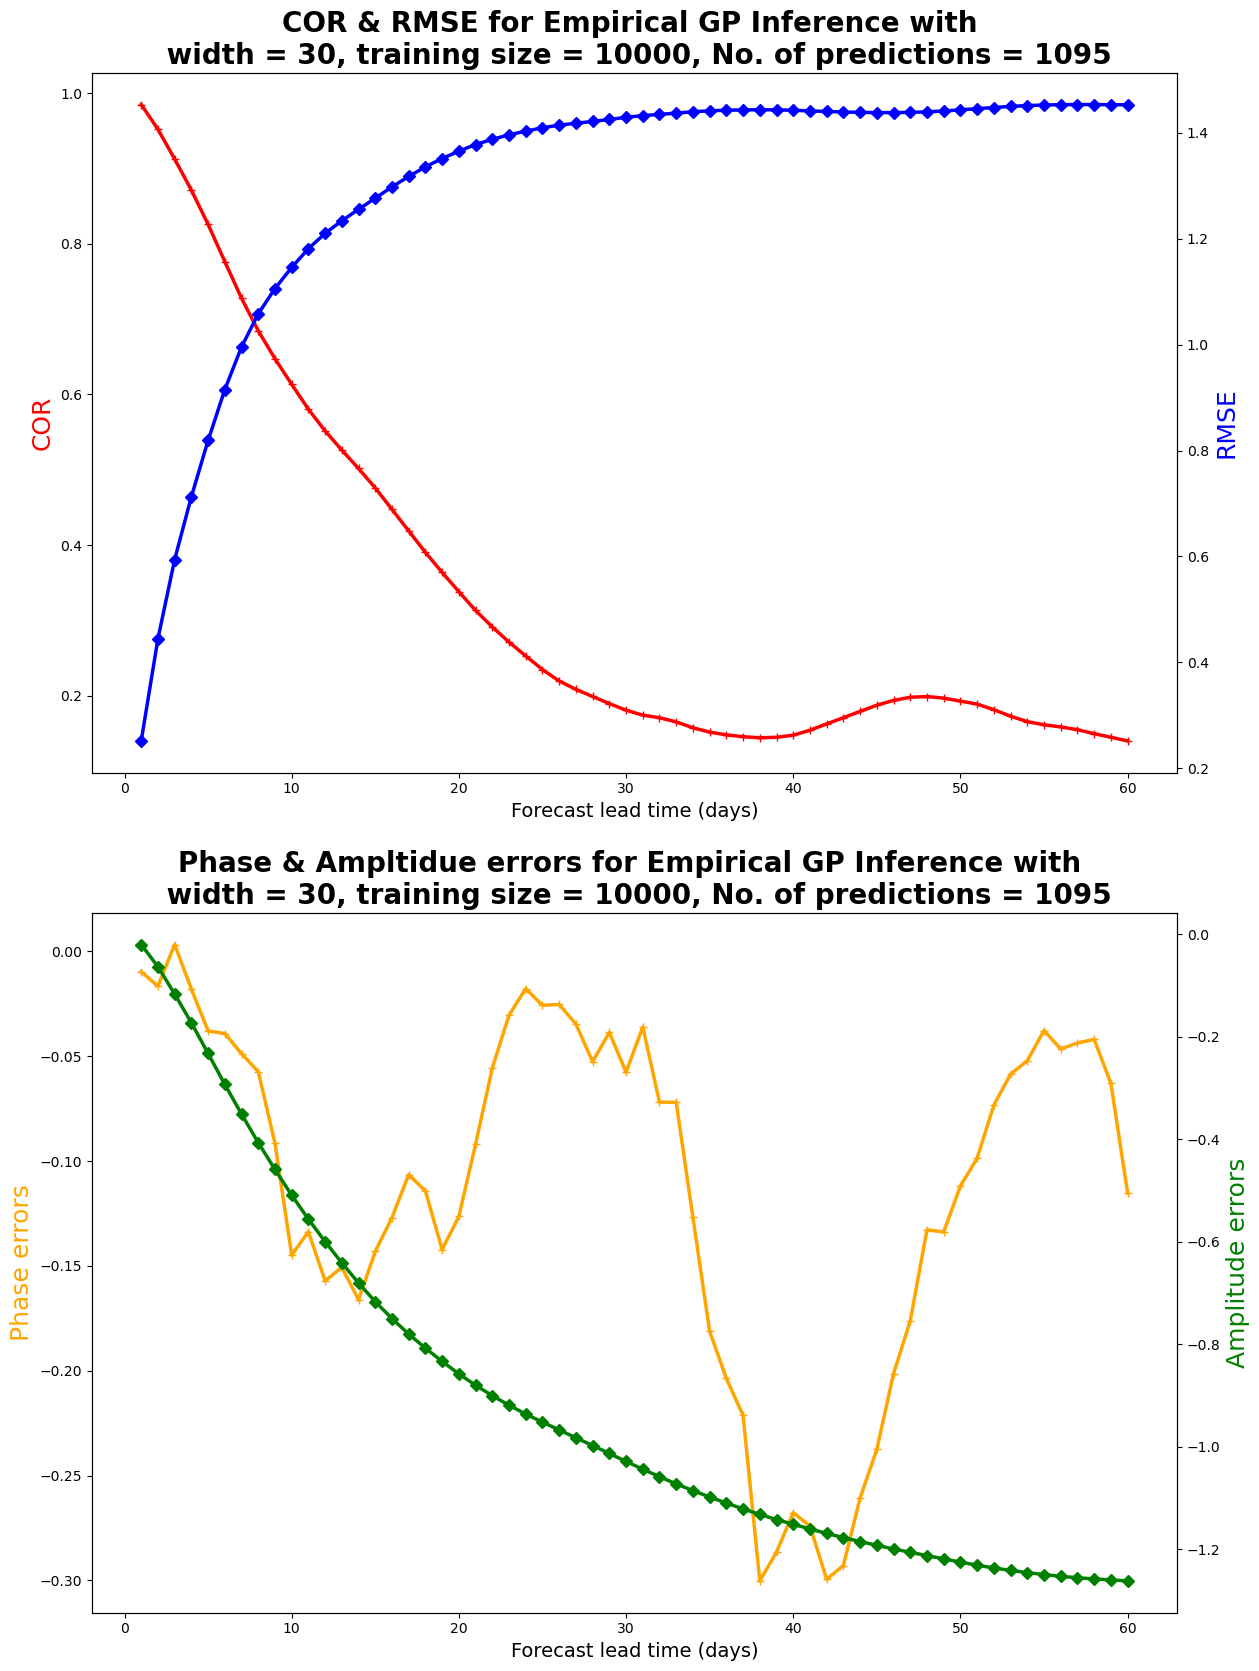

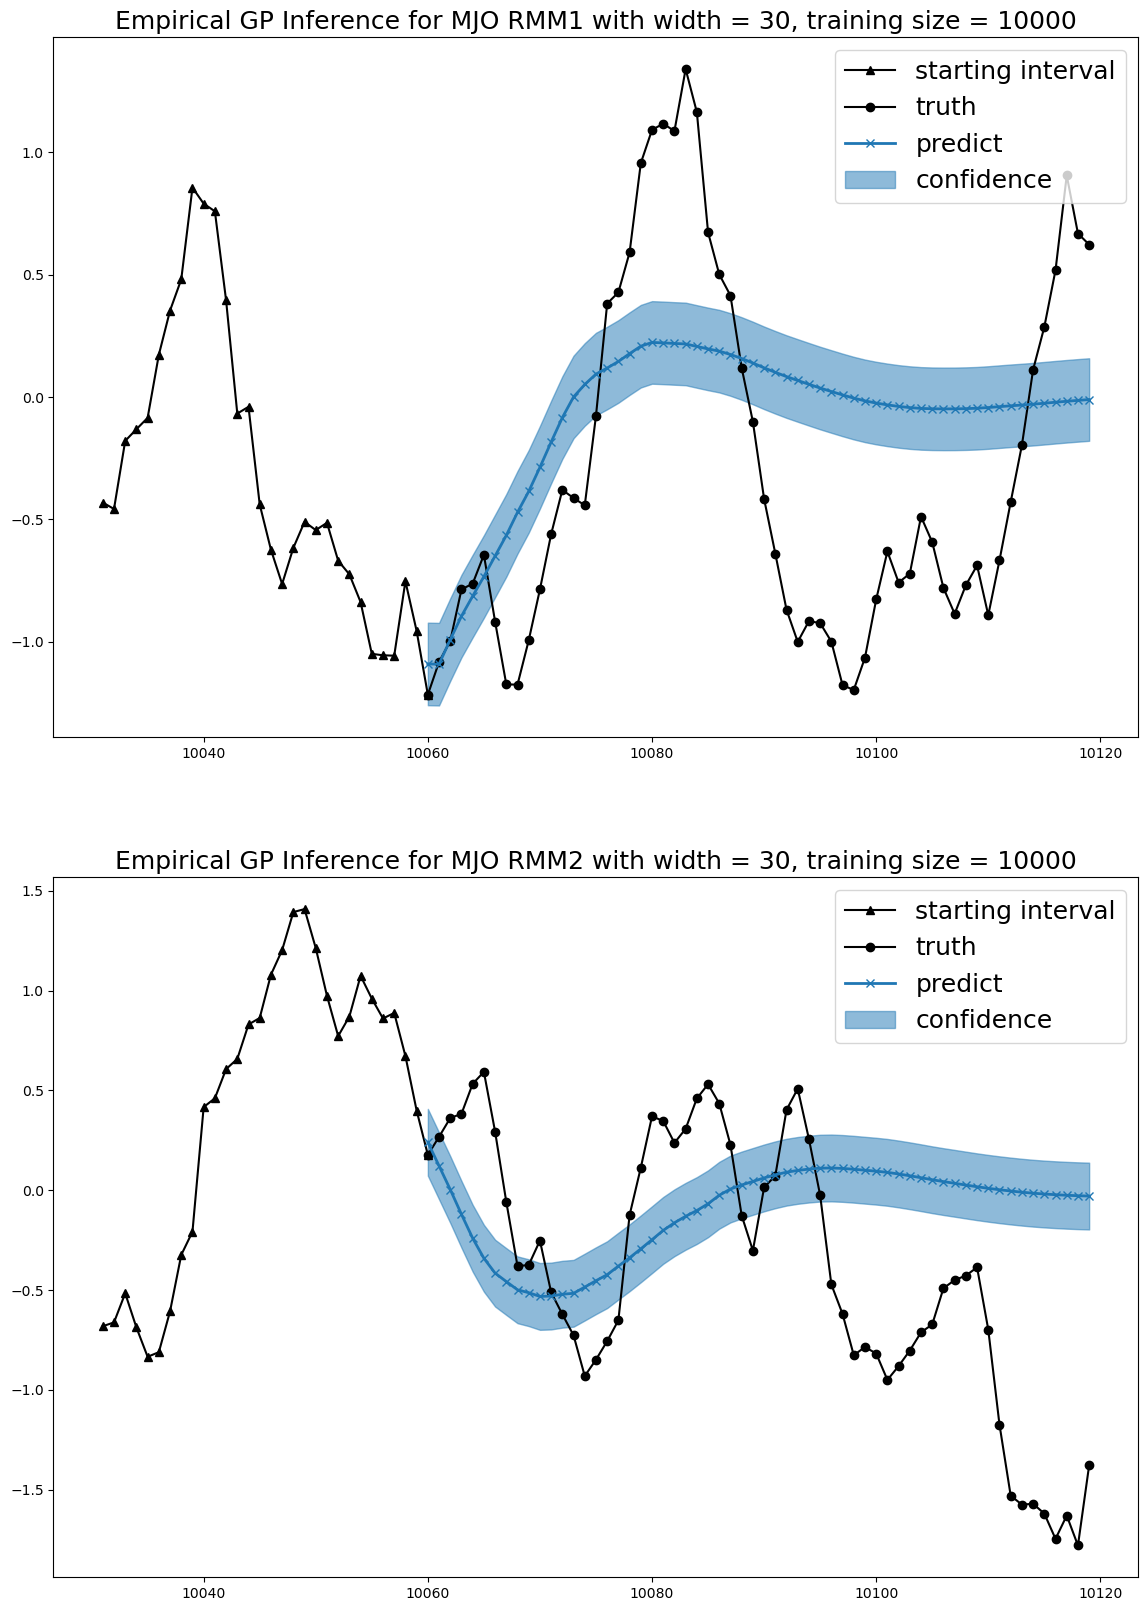

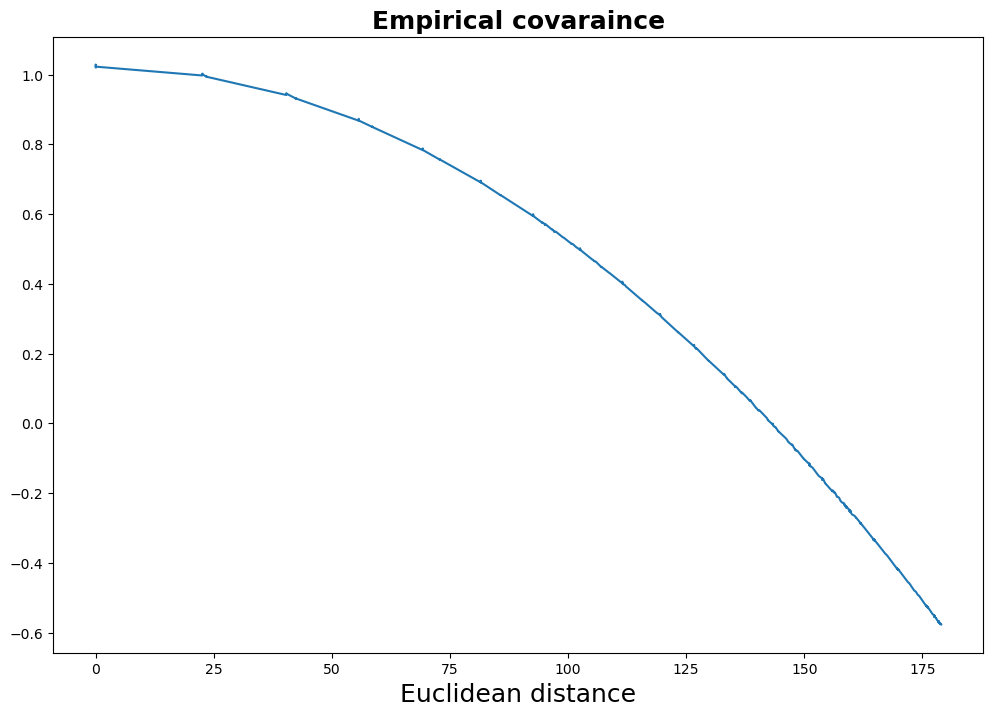

In [12]:
import matplotlib.colors as mcolors
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
color = palette_colors[0]
rmms = ['RMM1','RMM2']

# Plot errors
fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
ax0 = axs[0].twinx()
axs[0].plot(np.arange(1,lead_time+1), cor_entire, color='red', linewidth=2.5, marker='+')
ax0.plot(np.arange(1,lead_time+1), rmse_entire, color='blue', linewidth=2.5, marker='D')

axs[0].set_xlabel('Forecast lead time (days)', fontsize=14)
axs[0].set_ylabel('COR', color= 'red', fontsize=18)
ax0.set_ylabel('RMSE', color = 'blue', fontsize=18)
axs[0].set_title(f'COR & RMSE for Empirical GP Inference with \n width = {width}, training size = {n}, No. of predictions = {n_pred}', fontsize=20, fontweight="bold")

ax1 = axs[1].twinx()
axs[1].plot(np.arange(1,lead_time+1), phase_err_entire, color='orange', linewidth=2.5, marker='+')
ax1.plot(np.arange(1,lead_time+1), amplitude_err_entire, color='green', linewidth=2.5, marker='D')

axs[1].set_xlabel('Forecast lead time (days)', fontsize=14)
axs[1].set_ylabel('Phase errors', color='orange', fontsize=18)
ax1.set_ylabel('Amplitude errors', color='green', fontsize=18)
axs[1].set_title(f'Phase & Ampltidue errors for Empirical GP Inference with \n width = {width}, training size = {n}, No. of predictions = {n_pred}', fontsize=20, fontweight="bold")

# Plot predictions with observations
for i in range(1):#range(n_pred):
    start_ids = np.arange(i + start_test + width + 1 - width, i + start_test + width + 1)
    pred_ids = np.arange(i + start_test + width, i + start_test + width + lead_time)
    fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
    for k, rmm in enumerate(rmms):
        axs[k].plot(start_ids, npzfile[rmm][start_ids], color='black', marker='^')
        axs[k].plot(pred_ids, obs[rmm][i,:], color='black', marker='o')
        # Plot predictive means as blue line
        axs[k].plot(pred_ids, observed_preds[rmm][i,:], color, linewidth=2, marker='x')
        # shade between the lower and upper confidence bounds
        axs[k].fill_between(pred_ids, lower_confs[rmm][i,:], upper_confs[rmm][i,:], alpha=0.5, color=color)
        axs[k].legend(['starting interval', 'truth', 'predict', 'confidence'],fontsize=18)
        axs[k].set_title(f'Empirical GP Inference for MJO {rmm} with width = {width}, training size = {n}',fontsize=18)


# Plot covariance versus Euclidean distance
iu = np.triu_indices(len(dist_joint))
dist_joint_unfold = dist_joint[iu]
emp_jointcov_unfold = train_jointcov[iu]
print(dist_joint_unfold.shape)
print(emp_jointcov_unfold.shape)

arrind = dist_joint_unfold.argsort()
sorted_dist_joint = dist_joint_unfold[arrind]
sorted_emp_jointcov = emp_jointcov_unfold[arrind]

plt.figure(figsize=(12,8))
plt.plot(sorted_dist_joint, sorted_emp_jointcov)
plt.xlabel('Euclidean distance', fontsize=18)
plt.title('Empirical covaraince', fontsize=18, fontweight="bold")
plt.show()

## Season

In [13]:
## Divide new_datas into four seasons
npz_month = npzfile['month']
winter_ids = np.where( (npz_month==12) | (npz_month==1) | (npz_month==2) )[0]
spring_ids = np.where( (npz_month==3) | (npz_month==4) | (npz_month==5) )[0]
summer_ids = np.where( (npz_month==6) | (npz_month==7) | (npz_month==8) )[0]
fall_ids = np.where( (npz_month==9) | (npz_month==10) | (npz_month==11) )[0]

print(npz_month.shape)
print(winter_ids.shape)
print(spring_ids.shape)
print(summer_ids.shape)
print(fall_ids.shape)

#========================================================
# create season dataset
#========================================================
seasons = ['winter','spring','summer','fall']
seasons_ids = [winter_ids, spring_ids, summer_ids, fall_ids]
data_names = npzfile.files + ['id']
n_files = len(data_names)

season_npzfile = {}
for j in range(4):
    season = seasons[j]
    season_id = seasons_ids[j]

    new_npzfile = {} #[0]*n_files
    for i, data_name in enumerate(data_names):
        if i < n_files-1:
            new_npzfile[data_name] = npzfile[data_name][season_id]
        if i == n_files-1:
            new_npzfile[data_name] = season_id

    season_npzfile[season] = new_npzfile

(16026,)
(3940,)
(4048,)
(4048,)
(3990,)


In [14]:
Ns = [len(winter_ids),len(spring_ids),len(summer_ids),len(fall_ids)]# the total number of days in new dataset
n = 2500 # the number of days for training
ms = [N-n-365 for N in Ns] # the number of days for testing
print(ms)

width = 30
lead_time = 60
start_train = 0
n_offset = 0
n_pred = 100

n_train = width + n
start_test = start_train + n_train + n_offset


dist_joint = {}
train_jointcov = {}

pred_ids = {}
obs = {}
observed_preds = {}
lower_confs = {}
upper_confs = {}

cor_season = {}
rmse_season = {}
phase_err_season = {}
amplitude_err_season = {}

for m, season in zip(ms, seasons):
    emp_model = emp_gp_mjo(npzfile=season_npzfile[season], width=width, n=n, start_train=start_train, season_bool=True)
    emp_model.get_emp()
    emp_model.pred(start_test=start_test, lead_time=lead_time, n_pred=n_pred, m=m, season_bool=True)
    
    # compute errors
    cor_season[season] = emp_model.cor()
    rmse_season[season] = emp_model.rmse()
    phase_err_season[season] = emp_model.phase_err()
    amplitude_err_season[season] = emp_model.amplitude_err()

    dist_joint[season] = emp_model.dist_joint
    train_jointcov[season] = emp_model.train_jointcov

    pred_ids[season] = emp_model.pred_ids
    obs[season] = emp_model.obs
    observed_preds[season] = emp_model.observed_preds
    lower_confs[season] = emp_model.lower_confs
    upper_confs[season] = emp_model.upper_confs

[1075, 1183, 1183, 1125]
the number of predictions is greater than the number of the season intervals..., will set n_pred = 14
the number of predictions is greater than the number of the season intervals..., will set n_pred = 36
the number of predictions is greater than the number of the season intervals..., will set n_pred = 36
the number of predictions is greater than the number of the season intervals..., will set n_pred = 24


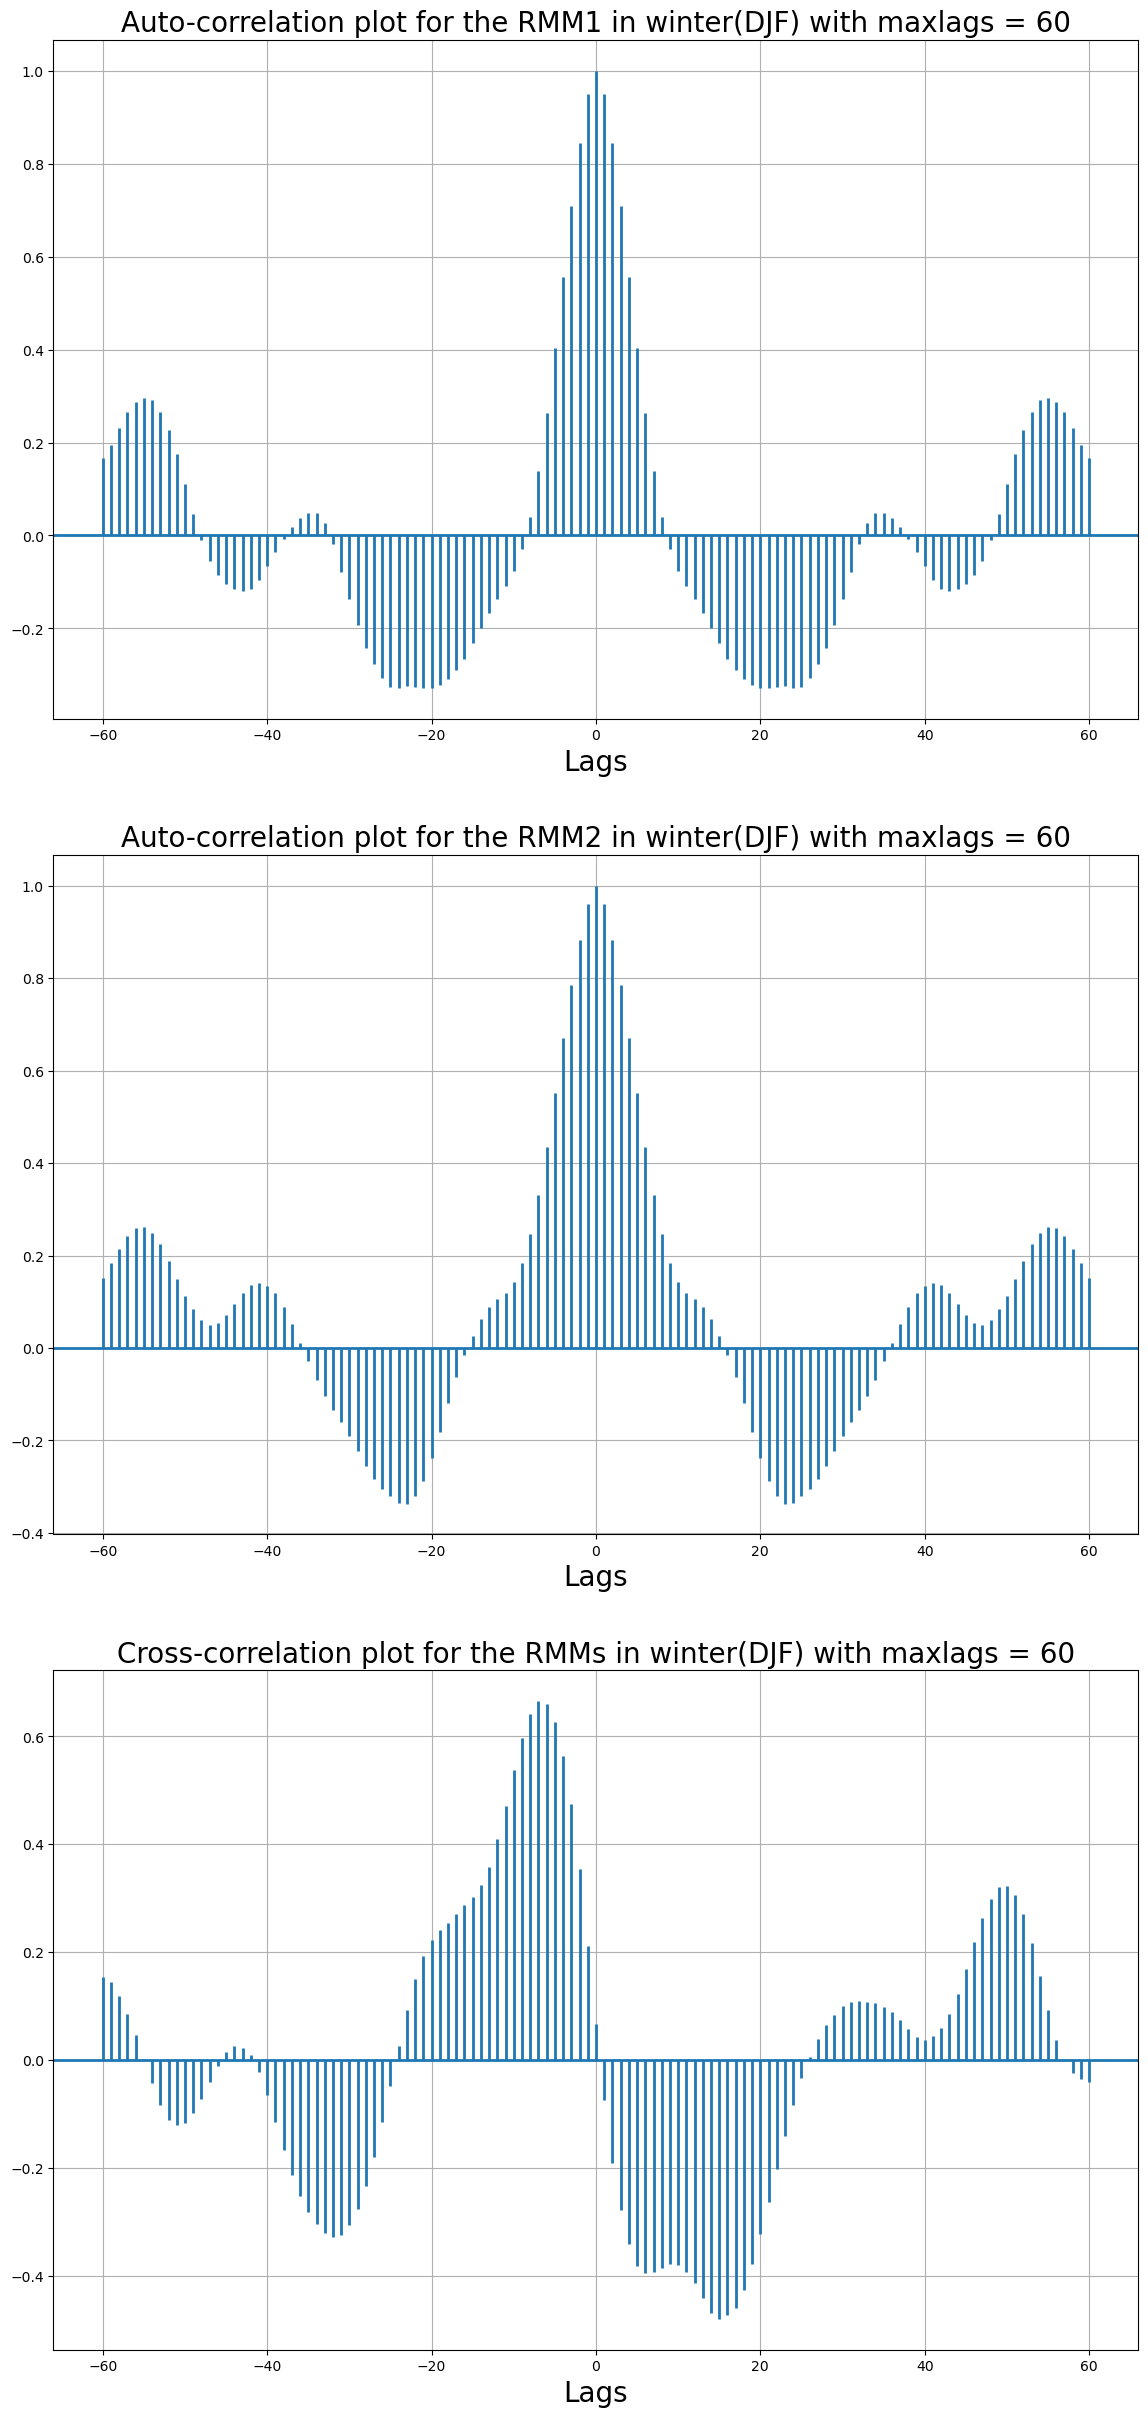

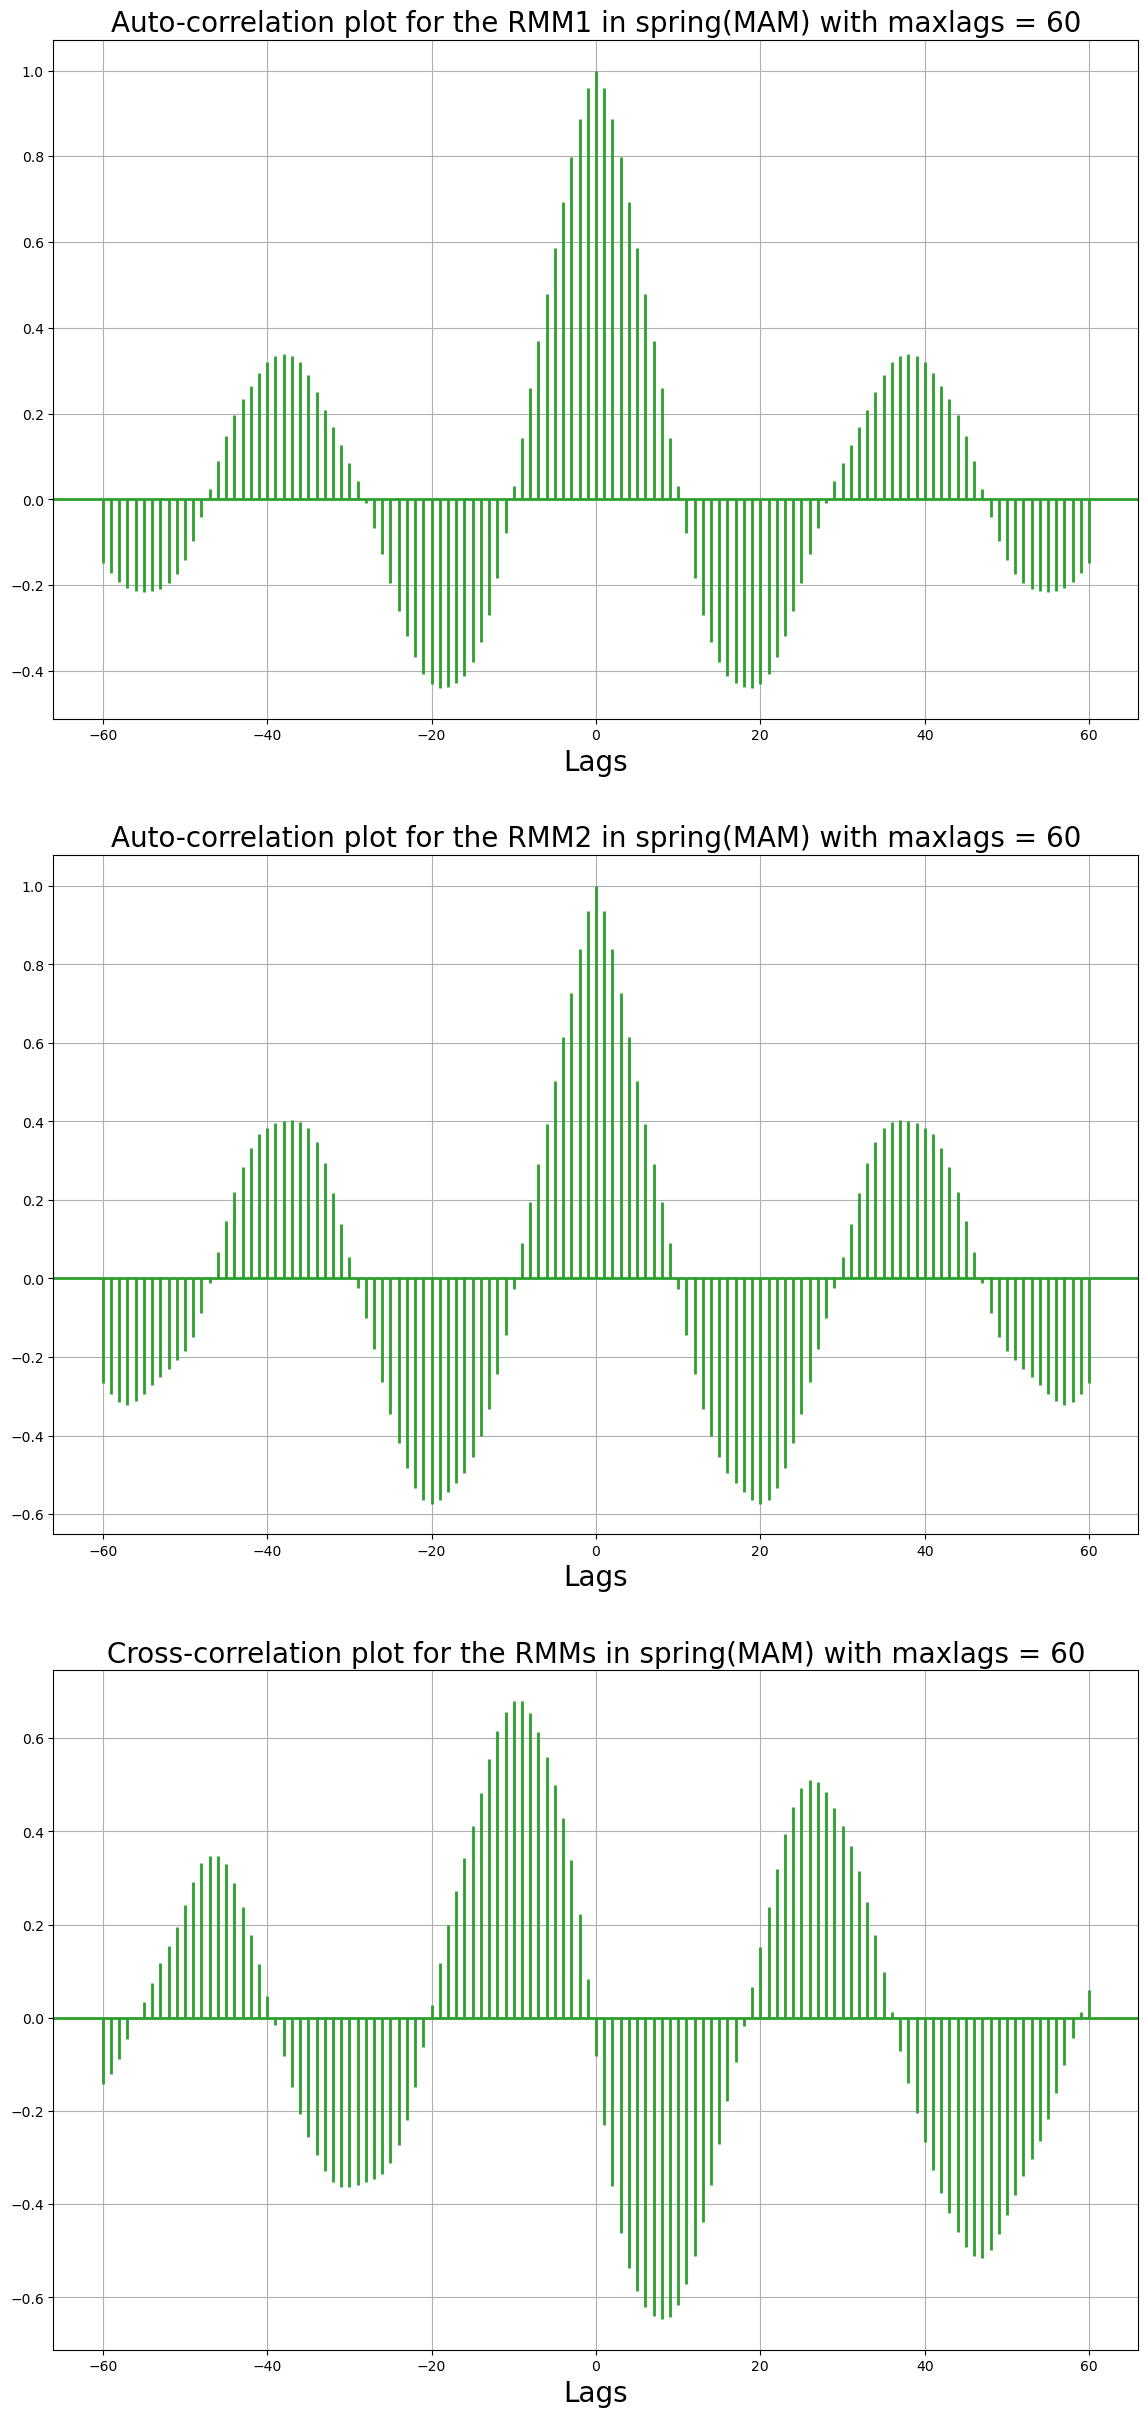

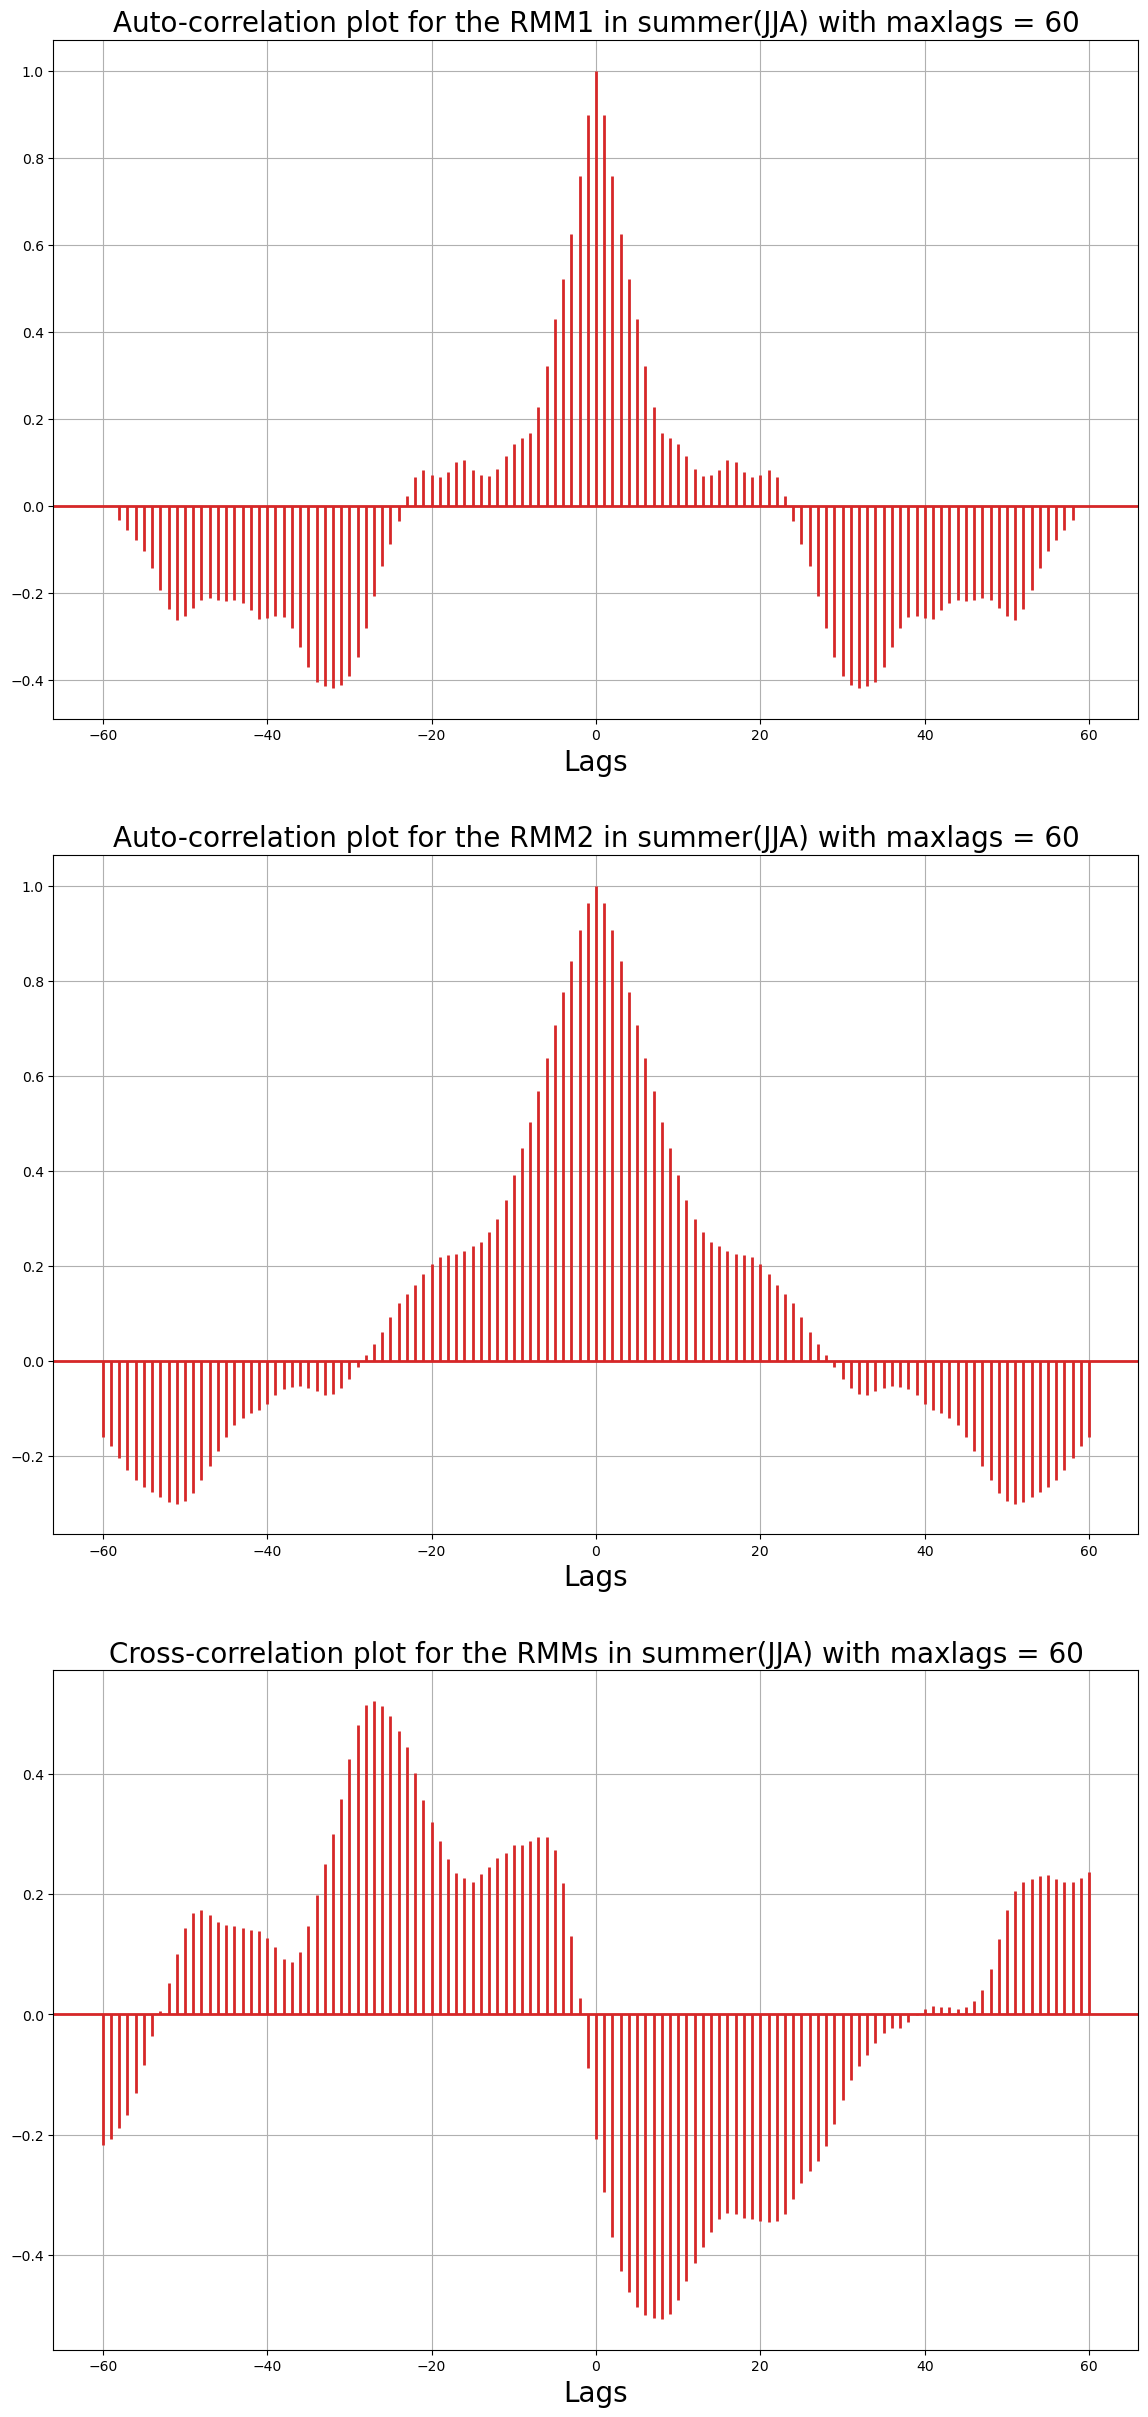

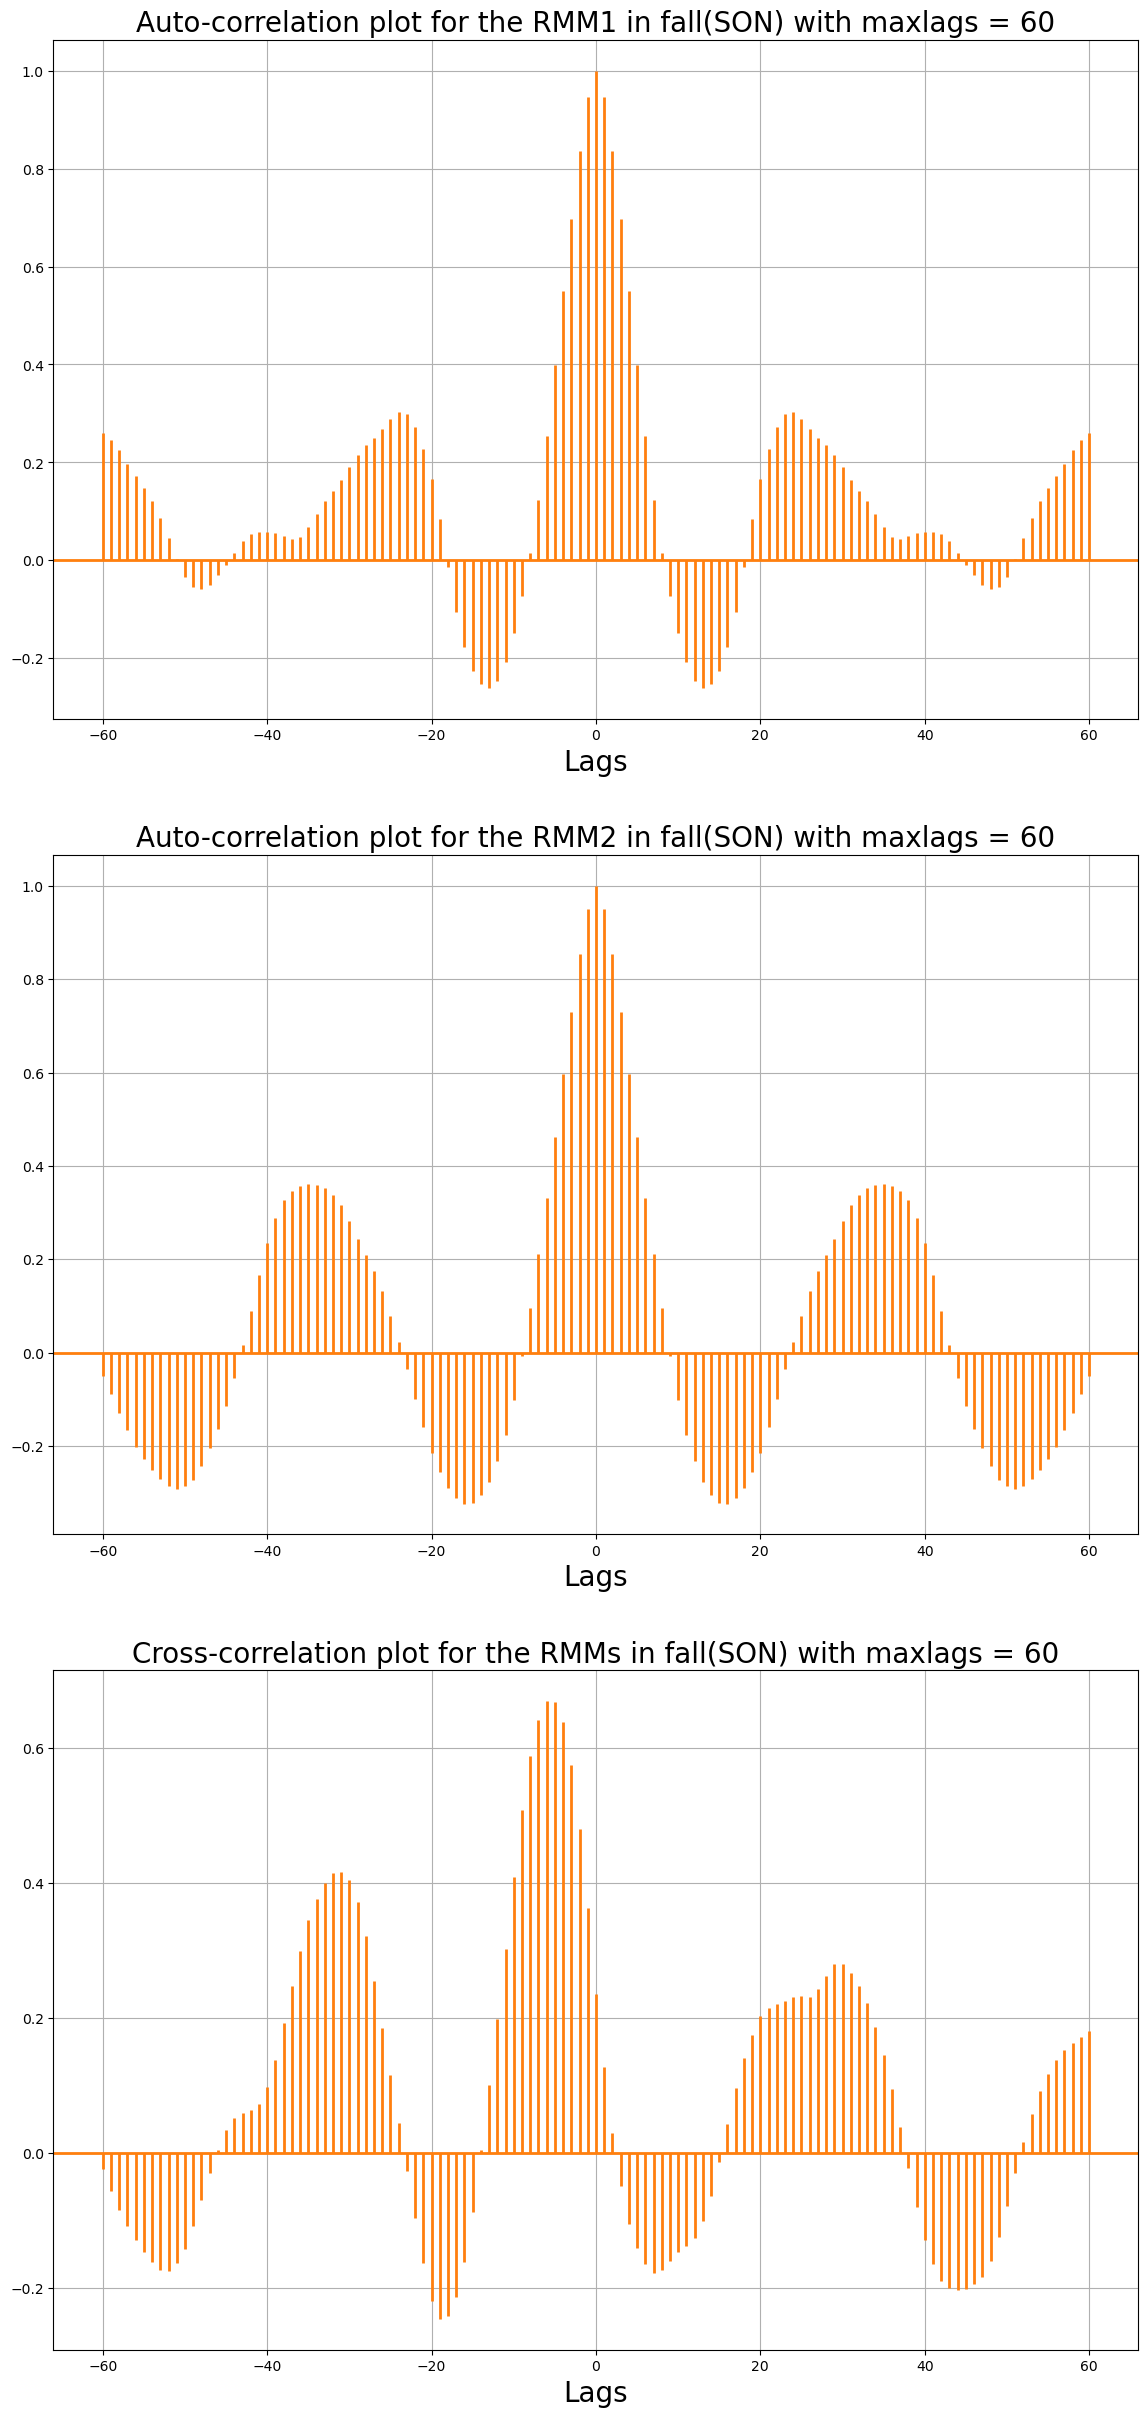

In [15]:
# Plot auto-correlation and cross-correlation
maxlags = 60
seasons = ['winter','spring','summer','fall']
season_months = ['winter(DJF)','spring(MAM)','summer(JJA)','fall(SON)']
plot_colors = ['tab:blue','tab:green','tab:red','tab:orange']

for season, season_month, color in zip(seasons, season_months, plot_colors):
    start_id_season = ( np.where(np.ediff1d(season_npzfile[season]['id']) != 1 )[0]+1 )[2]
    fig, axs = plt.subplots(3, 1, figsize=(14, 10*3))
    for k, rmm in enumerate(['RMM1','RMM2']):
        axs[k].acorr(season_npzfile[season][rmm][start_id_season: start_id_season+90], usevlines=True, maxlags=maxlags, normed=True, lw=2, color=color)
        axs[k].set_xlabel('Lags', fontsize=20)
        axs[k].set_title(f'Auto-correlation plot for the {rmm} in {season_month} with maxlags = {maxlags}', fontsize=20)
        axs[k].grid(True)
    axs[2].xcorr(season_npzfile[season]['RMM1'][start_id_season: start_id_season+90], season_npzfile[season]['RMM2'][start_id_season: start_id_season+90], usevlines=True, normed=True, maxlags=maxlags, lw=2, color=color)
    axs[2].set_xlabel('Lags', fontsize=20)
    axs[2].set_title(f'Cross-correlation plot for the RMMs in {season_month} with maxlags = {maxlags}', fontsize=20)
    axs[2].grid(True)

plt.show()

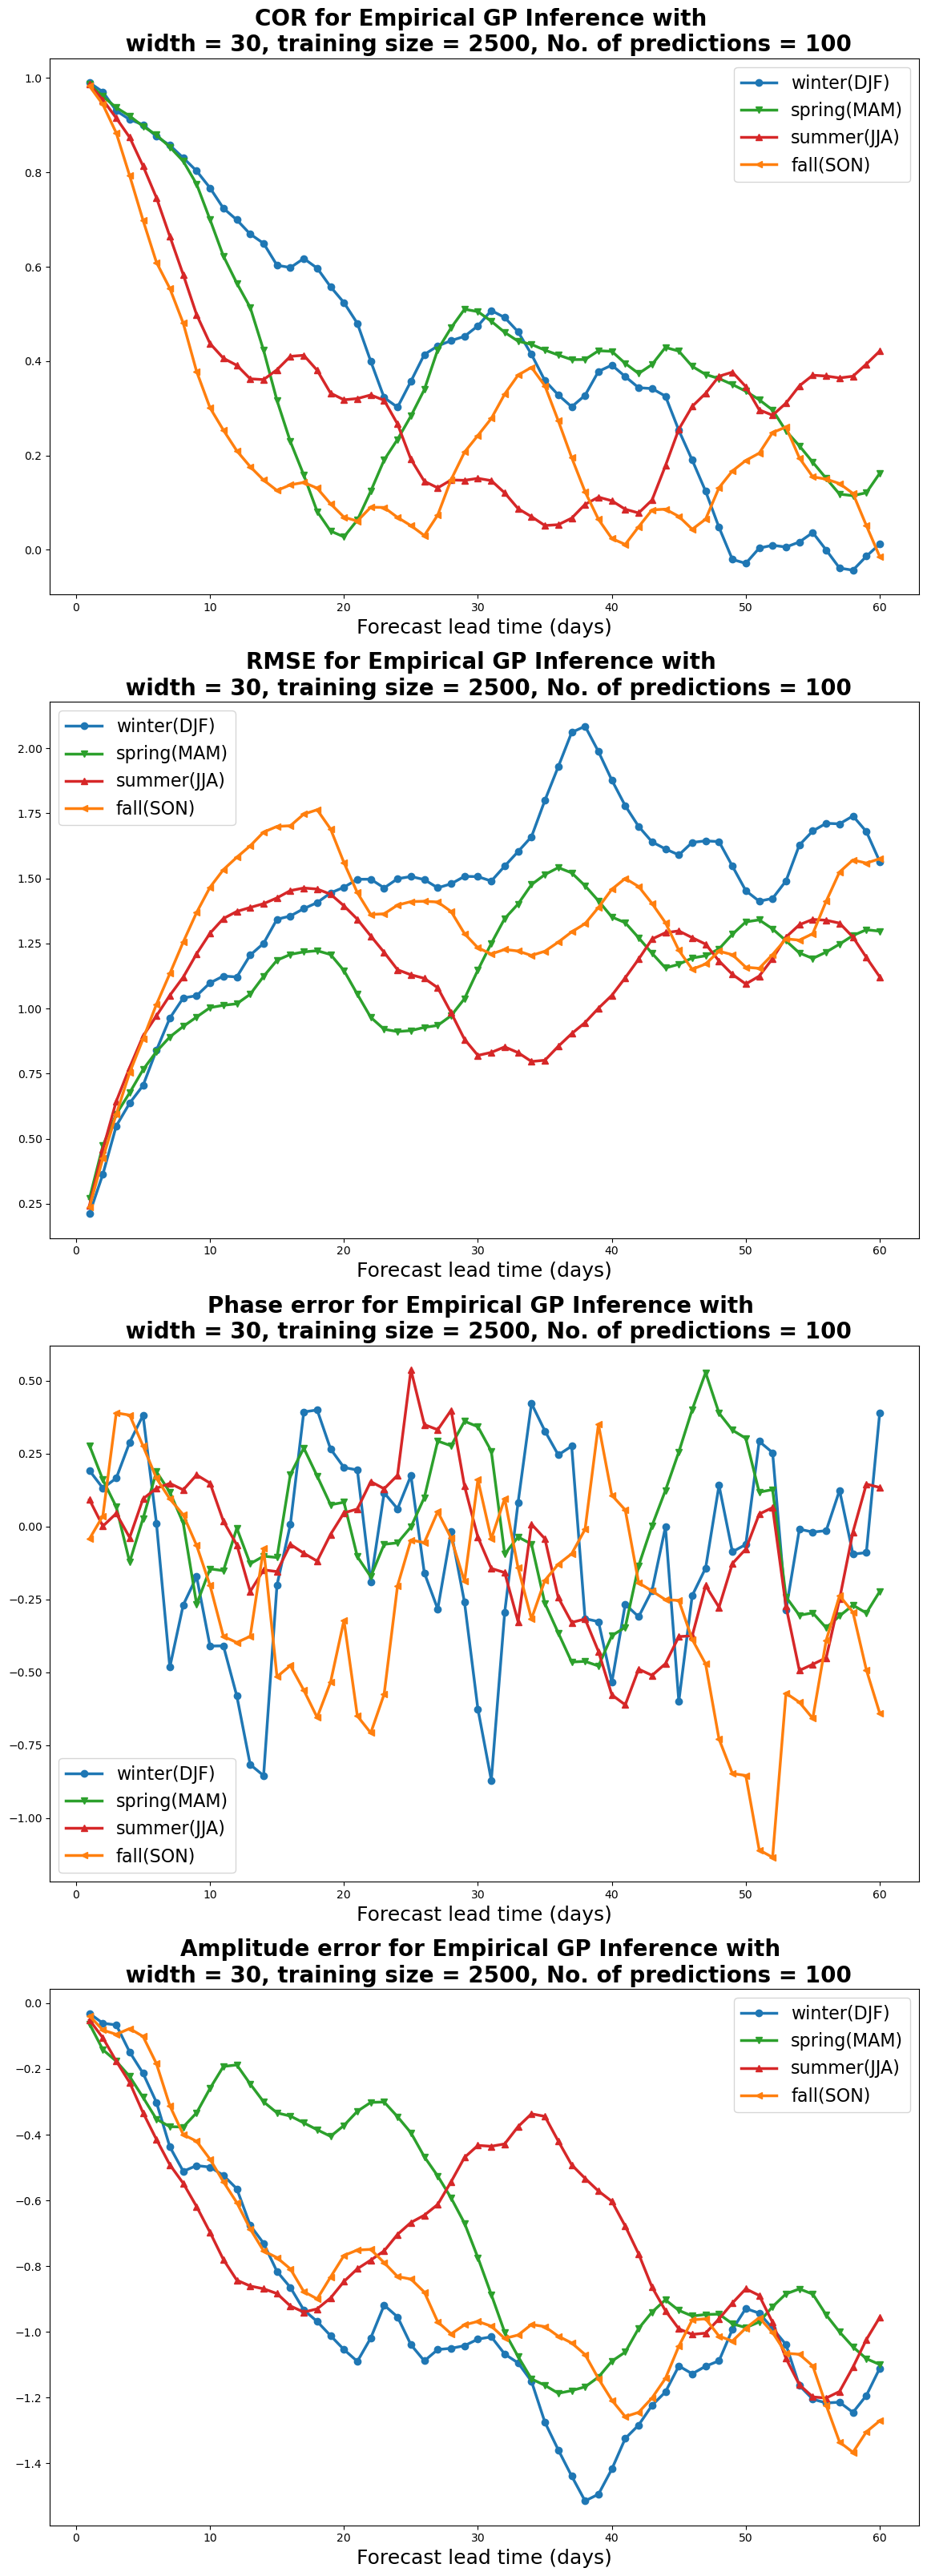

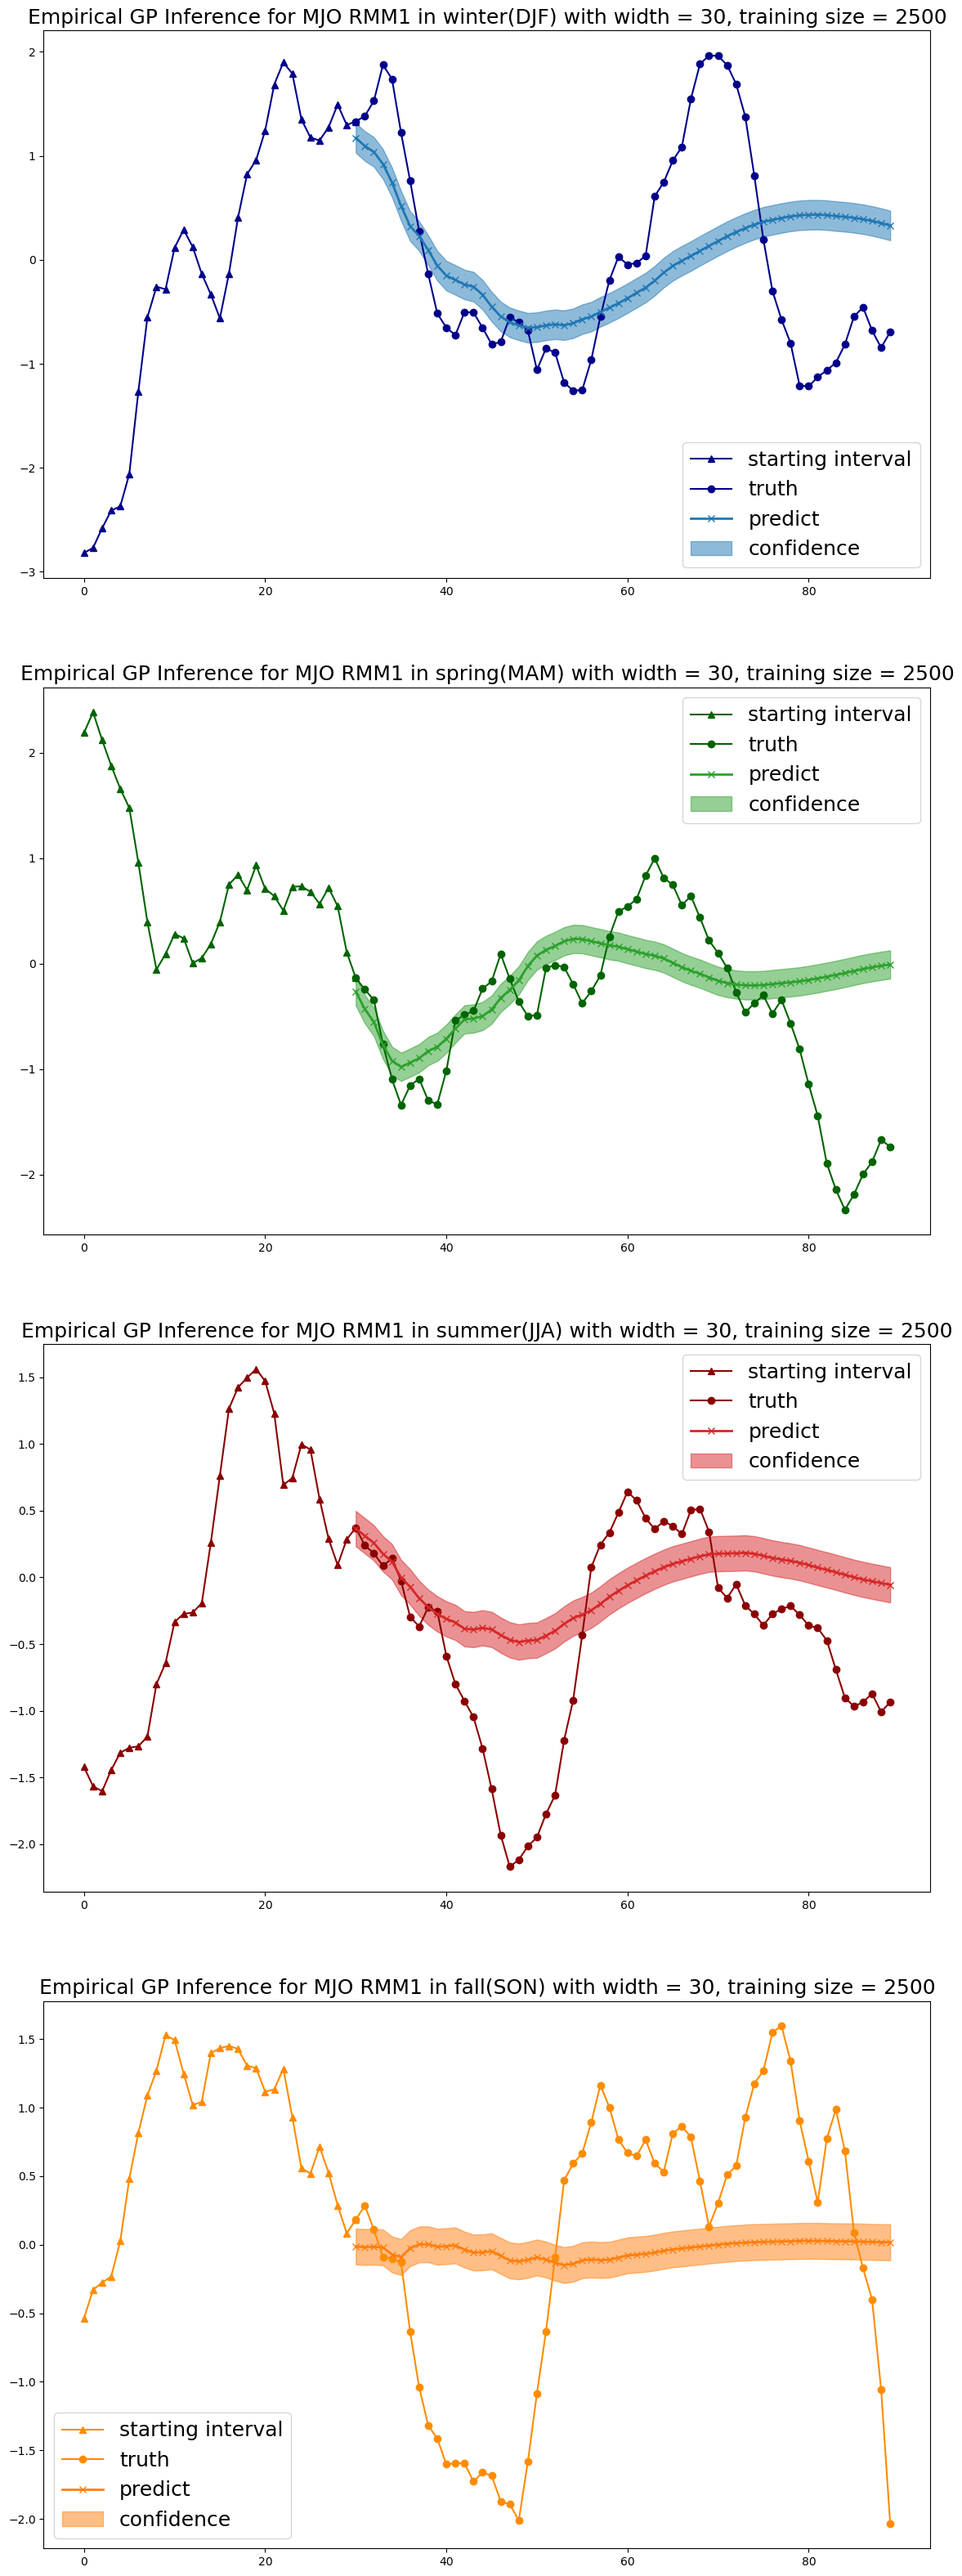

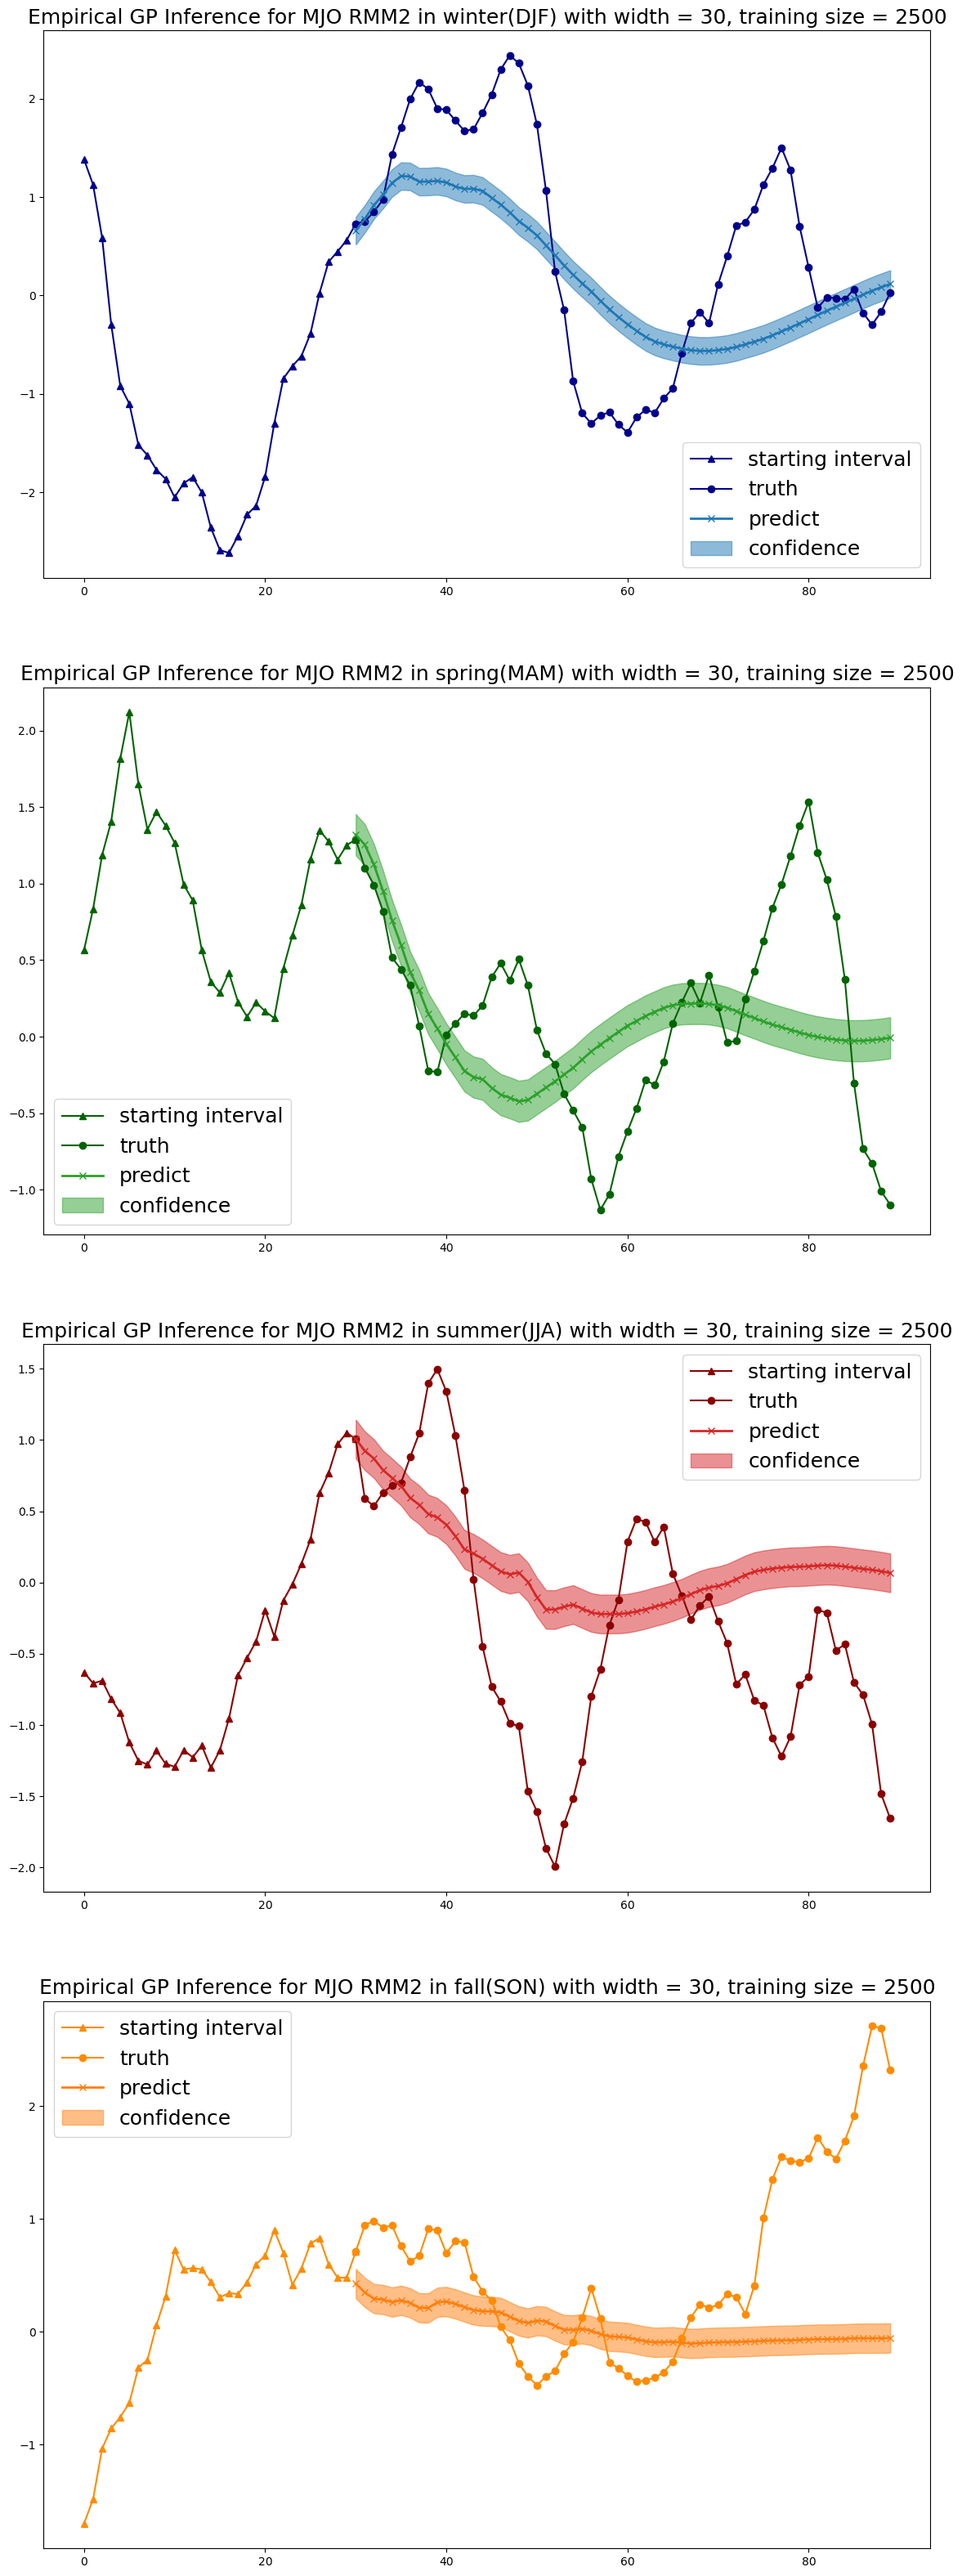

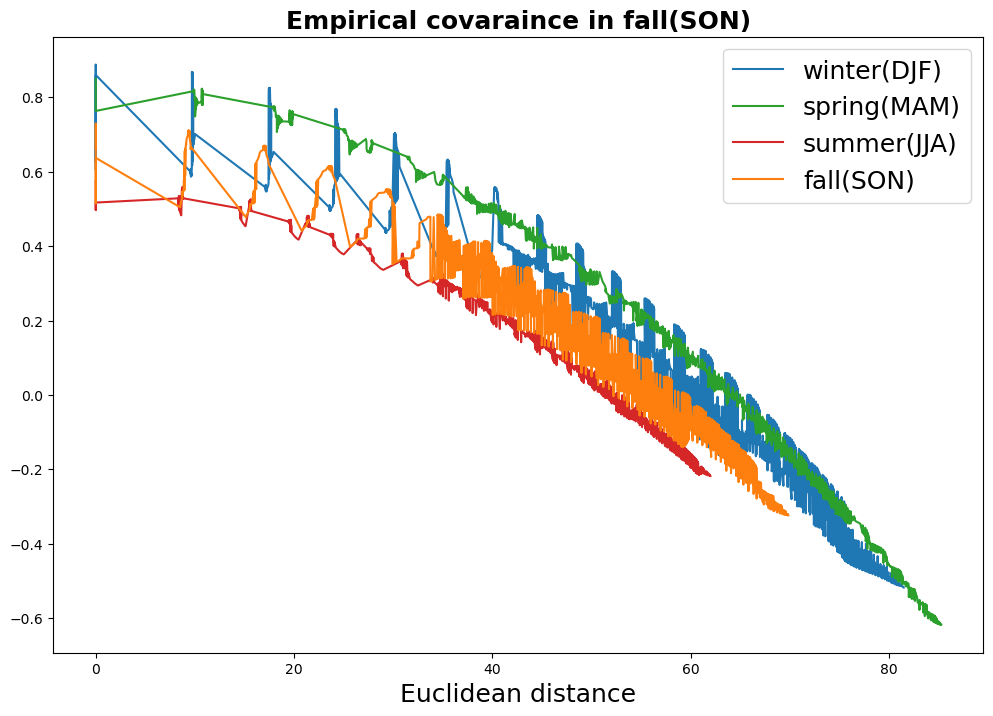

In [16]:
from matplotlib.markers import MarkerStyle
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']
season_months = ['winter(DJF)','spring(MAM)','summer(JJA)','fall(SON)']
plot_colors = ['tab:blue','tab:green','tab:red','tab:orange']
dark_colors = ['darkblue','darkgreen','darkred','darkorange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]
rmms = ['RMM1','RMM2']

# Plot errors
fig, axs = plt.subplots(4, 1, figsize=(14, 10*4))
for season, color, marker in zip(seasons, plot_colors, plot_markers):
    _cor = cor_season[season]
    _rmse = rmse_season[season]
    _phase_err = phase_err_season[season]
    _amplitude_err = amplitude_err_season[season]
    
    
    axs[0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=2.5, marker=marker)
    axs[1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=2.5, marker=marker)
    axs[2].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=2.5, marker=marker)
    axs[3].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=2.5, marker=marker)

for i, mjo_err in enumerate(mjo_errs):
    axs[i].set_xlabel('Forecast lead time (days)', fontsize=18)
    axs[i].legend(season_months, fontsize=16)
    axs[i].set_title(f'{mjo_err} for Empirical GP Inference with \n width = {width}, training size = {n}, No. of predictions = {n_pred}', fontsize=20, fontweight="bold")

# Plot predictions with observations
test_ids = np.arange(start_test, start_test + max(ms))
for i in range(1):#range(n_pred):
    # start_ids = np.arange(i + start_test + width + 1 - width, i + start_test + width + 1)
    # pred_ids = np.arange(i + start_test + width, i + start_test + width + lead_time)
    start_ids = np.arange(season_npzfile[season]['id'][test_ids[pred_ids[season][i]]], season_npzfile[season]['id'][test_ids[pred_ids[season][i]+width+1]])
    pred_ids_season = np.arange(season_npzfile[season]['id'][test_ids[pred_ids[season][i]+width]], season_npzfile[season]['id'][test_ids[pred_ids[season][i]+width+lead_time]])
    for rmm in rmms:
        fig, axs = plt.subplots(4, 1, figsize=(14, 10*4))
        for k, season in enumerate(seasons):
            color = plot_colors[k]
            darkcolor = dark_colors[k]
            season_month = season_months[k]
            axs[k].plot(np.arange(width+1), season_npzfile[season][rmm][test_ids[pred_ids[season][i]: pred_ids[season][i]+width+1]], color=darkcolor, marker='^')
            axs[k].plot(np.arange(width, width+lead_time), obs[season][rmm][i,:], color=darkcolor, marker='o')
            # Plot predictive means as blue line
            axs[k].plot(np.arange(width, width+lead_time), observed_preds[season][rmm][i,:], color=color, linewidth=2, marker='x')
            # shade between the lower and upper confidence bounds
            axs[k].fill_between(np.arange(width, width+lead_time), lower_confs[season][rmm][i,:], upper_confs[season][rmm][i,:], alpha=0.5, color=color)
        
            axs[k].legend(['starting interval', 'truth', 'predict', 'confidence'],fontsize=18)
            axs[k].set_title(f'Empirical GP Inference for MJO {rmm} in {season_month} with width = {width}, training size = {n}',fontsize=18)


# Plot covariance versus Euclidean distance
plt.figure(figsize=(12,8))
for season, season_month, color in zip(seasons, season_months, plot_colors):
    iu = np.triu_indices(len(dist_joint[season]))
    dist_joint_unfold = dist_joint[season][iu]
    emp_jointcov_unfold = train_jointcov[season][iu]
    # print(dist_joint_unfold.shape)
    # print(emp_jointcov_unfold.shape)

    arrind = dist_joint_unfold.argsort()
    sorted_dist_joint = dist_joint_unfold[arrind]
    sorted_emp_jointcov = emp_jointcov_unfold[arrind]

    plt.plot(sorted_dist_joint, sorted_emp_jointcov, color=color)
plt.legend(season_months, fontsize=18)
plt.xlabel('Euclidean distance', fontsize=18)
plt.title(f'Empirical covaraince in {season_month}', fontsize=18, fontweight="bold")
plt.show()